# Caso de estudio: reconocimiento de dígitos manuscritos

## Dataset
El dataset que se utilizará en este caso de uso es el conjunto de datos MNIST, que contiene imágenes de dígitos escritos a mano.

Este conjunto de datos se puede descargar de la página *The MNIST database* y está formado por 60000 imágenes para entrenar modelos y otras 10000 imágenes adicionales para testearlos. 

Este ejemplo es perfecto para comenzar a trabajar con técnicas de reconocimientos de patrones, ya que no requiere dedicar mucho tiempo al preprocesado de los datos. 

Las imágenes han sido normalizadas a 28x28 píxeles, conservando su relación de aspecto. 

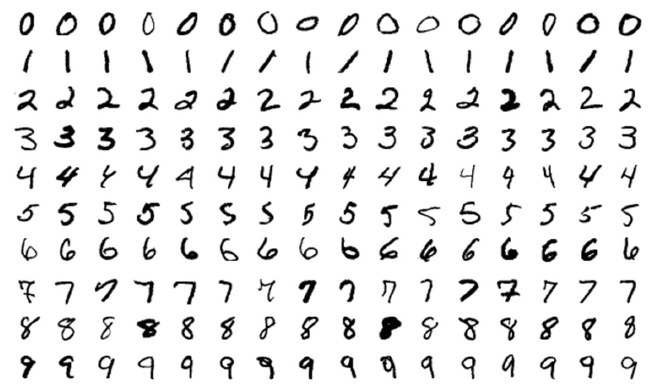

Veamos, por ejemplo, la octava muestra del dataset:

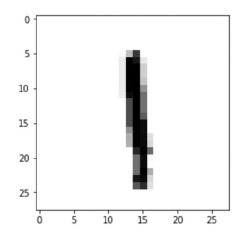

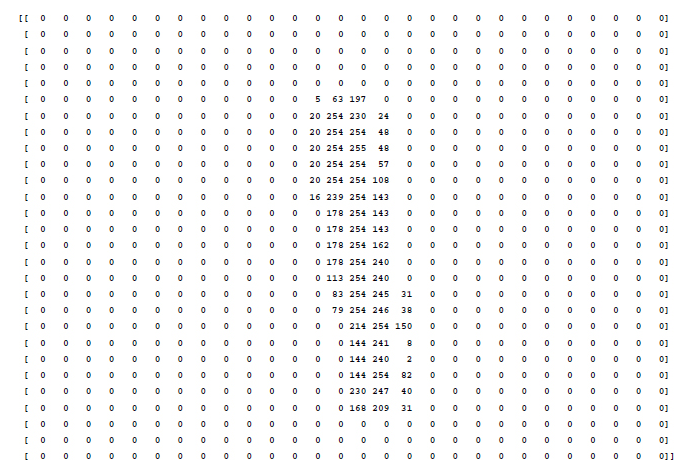

Esta última muestra la matriz de intensidades de cada uno de los 28x28 píxeles mediante valores comprendidos entre [0, 255], donde el 0 representa el negro y el 255, el blanco.

Por otro lado, cada imagen de un dígito se encuentra asociada a una etiqueta que indica el dígito que representa (entre el 0 y el 9). 

## Tipo de problema
El objetivo es que, dada una imagen, se obtengan las probabilidades de que dicha imagen corresponda a uno de los 10 posibles dígitos. 

Por tanto, para cada dato de entrada se ha de obtener un vector de salida de la red neuronal con una distribución de probabilidad sobre un conjunto de etiquetas mutuamente excluyentes. Es decir, se obtendrá un vector con 10 probabilidades, cada una de las cuales corresponde a un dígito, y la suma de esas 10 probabilidades debe ser 1. 

## Carga de los datos en Keras
Keras ya dispone de este dataset precargado en forma de cuatro arrays de NumPy:

In [10]:
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

In [8]:
mnist = datasets.mnist
mnist

<module 'tensorflow.keras.datasets.mnist' from '/home/alba/.conda/envs/vehicles/lib/python3.8/site-packages/tensorflow/keras/datasets/mnist/__init__.py'>

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Exploración de datos

Veamos una imagen cualquiera del dataset de train y su etiqueta asociada:

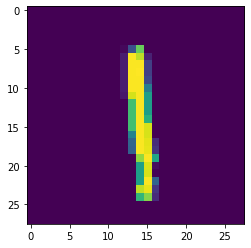

In [12]:
plt.imshow(X_train[8]) 

In [13]:
y_train[8]

1

Veamos ahora las dimensiones de X_train y el tipo de datos que contiene:

In [15]:
X_train.shape

(60000, 28, 28)

In [16]:
X_train.dtype

dtype('uint8')

Por tanto, X_train tiene 3D y contiene enteros de 8 bits. 

En concreto, es un vector de 60000 matrices 2D de 28x28 enteros.

En general, una imagen en color suele tener tres dimensiones: 
    
- Altura
- Anchura
- Profundidad de color

Las imágenes en escala de grises tienen un solo canal de color y, por tanto, pueden almacenarse en matrices 2D. Aún así, también es habitual encontrarlas en vectores 3D con un único canal de color. 

Por ejemplo, 60000 imágenes en escala de grises de tamaño 28x28 podrían almacenarse en un vector de forma (60000, 28, 28, 1). 

En cambio, si dichas imágenes tuvieran color, se almacenarían en una estructura (60000, 28, 28, 3). En este caso, hay 3 canales de color usando la codificación RGB.

Es decir, en los dos casos anteriores los datos se encuentran en un tensor 4D con forma (n_muestras, alto, ancho, canales).

En realidad, cualquier conjunto de datos se puede representar como un tensor. Por ejemplo, un vídeo podría venir dado por un tensor 5D con la forma (n_muestras, frames, alto, ancho, canales), ya que consiste en una secuencia de fotogramas (frames).

## Preprocesamiento de datos

Algunos de los preprocesamientos básicos en modelado con redes neuronales (y, en concreto, en Deep Learning), son la vectorización, la normalización y la extracción de características.  

### Normalización
En este ejemplo, las imágenes están representadas por valores de entre 0 y 255 de tipo uint8. Sin embargo, lo más habitual es escalar los valores de entrada de las redes neuronales a unos rangos determinados, lo que se conoce como *normalización*. Un rango muy común de normalización es el intervalo [0,1].

In [18]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Con la normalización, se consigue que la red converja de forma más fácil durante el entrenamiento, ya que, en general, para alimentar a redes neuronales no se usan datos con valores mucho más grandes que los de los pesos de la red, o datos que pertenezcan a rangos muy heterogéneos entre sí.

### Modificación de formato
Otra transformacón muy habitual es la modificación de la forma de los tensores, para lo que se suele utilizar la función *numpy.reshape()*. En general, se pasa de un tensor de 2D de una imagen a un vector de 1D.

En este ejemplo, cada matriz de 28x28 pasará a ser un vector de 784 números, lo que se llevará a cabo concatenando fila a fila. De esta forma, se adapta la entrada a la que acepta una red neuronal fully connected como la que se utilizará.

In [21]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [22]:
X_train.shape

(60000, 784)

### Codificación one-hot

In [23]:
from tensorflow.keras.utils import to_categorical

In [25]:
y_train[0]

5

In [24]:
y_test[0]

7

In [26]:
y_train.shape

(60000,)

In [27]:
y_test.shape

(10000,)

In [30]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [31]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [32]:
y_train.shape

(60000, 10)

## Definición del modelo
Keras dispone de una estructura de datos básica, la clase *Sequential*, que permite la creación de una red neuronal sencilla. Cualquier modelo en Keras se compone mediante una secuencia de capas, cada una de las cuales aplica una cierta transformación sobre los datos de su entrada para ir acercándolos al resultado deseado. 

Para este caso de uso, se va a implementar un modelo sencillo formado por una secuencia de dos capas densas que están completamente conectadas, es decir, todas las neuronas de la primera capa están conectadas con todas las neuronas de la segunda capa. La construcción de este modelo podría realizarse como se muestra a continuación:

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [39]:
model = Sequential()
model.add(Dense(10, activation = "sigmoid", input_shape = (784,)))
model.add(Dense(10, activation = "softmax"))

En este modelo, solo necesitamos indicar las dimensiones de los datos de entrada. Keras deducirá automáticamente la forma de los tensores entre capas después de la primera capa.

Lo que sí es necesario para cada capa es definir el número de nodos y la función de activación. Por ejemplo, para la primera capa se han definido 10 nodos y una función sigmoid, respectivamente.

Veamos un resumen del modelo:

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


Analicemos el número de parámetros:
    
- En la primera capa, por cada neurona i (entre 0 y 9) se necesitan 784 parámetros para los pesos wij y, por tanto, 10 * 784 parámetros para almacenar los pesos de las 10 neuronas. Además, hay que añadir 10 parámetros adicionales para los 10 sesgos bj correspondientes a cada neurona. La suma, por tanto, es de 7850 parámetros, tal y como se muestra en el resultado del método summary().
- En la segunda capa, se ha incluido una función softmax. Por tanto, se requiere conectar sus 10 neuronas con las 10 neuronas de la capa anterior. Es decir, son necesarios 10x10 parámetros wi, además de los 10 sesgos bj correspondientes a cada nodo. En total, son necesarios 110 parámetros.

# Proceso de aprendizaje

## Configuración
Una vez el modelo está definido, se ha de configurar cómo será el proceso de aprendizaje. Para ello, se utiliza el método *compile()*. 

En este método, se han de incluir ciertos argumentos:
- Función de coste para evaluar el grado de error entre las predicciones y los valores reales. 
- Un optimizador que permitirá a la red calcular los pesos de los parámetros durante el entrenamiento.
- Una métrica para monitorizar el proceso de aprendizaje y testeo de la red. En este ejemplo, se establecerá la precisión para medir la fracción de imágenes que se clasifican correctamente.

In [41]:
model.compile(loss = "categorical_crossentropy",
             optimizer = "sgd",
             metrics = ["accuracy"])

## Entrenamiento

In [42]:
model.fit(X_train, y_train, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 1s 598us/step - loss: 1.8552 - accuracy: 0.5294
Epoch 2/5
1875/1875 [==============================] - 1s 579us/step - loss: 1.2631 - accuracy: 0.7283
Epoch 3/5
1875/1875 [==============================] - 1s 584us/step - loss: 0.9649 - accuracy: 0.7842
Epoch 4/5
1875/1875 [==============================] - 1s 569us/step - loss: 0.7973 - accuracy: 0.8181
Epoch 5/5
1875/1875 [==============================] - 1s 590us/step - loss: 0.6903 - accuracy: 0.8407


# Evaluación

In [43]:
test_loss, test_acc = model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 517us/step - loss: 0.6353 - accuracy: 0.8556


La precisión indica que el modelo, al ser aplicado sobre datos nunca vistos con anterioridad, es capaz de clasificar correctamente el 86.61% de ellos.

Evaluemos ahora la matriz de confusión:

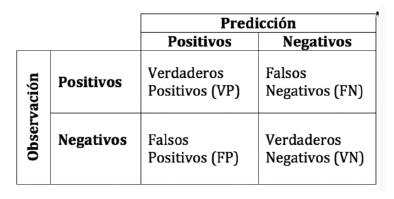

In [47]:
y_pred = model.predict_classes(X_test)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [49]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [51]:
from numpy import argmax
argmax(y_test, axis = 1)

array([7, 2, 1, ..., 4, 5, 6])

<AxesSubplot:>

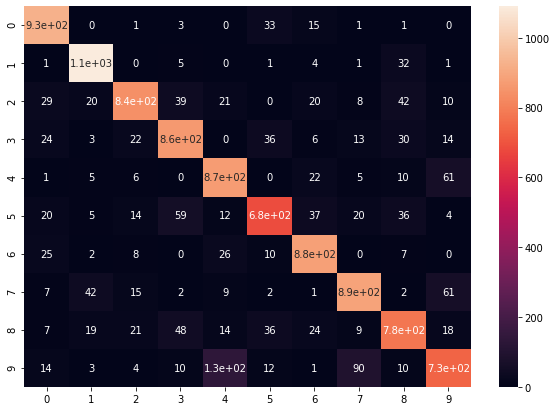

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(argmax(y_test, axis = 1), y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)